# W5 Project -Regression

**Background**: You are working as an analyst for a real estate company. Your company wants to build a machine learning model to predict the selling prices of houses based on a variety of features on which the value of the house is evaluated.

**Objective**: The task is to build a model that will predict the price of a house based on features provided in the dataset. The senior management also wants to explore the characteristics of the houses using some business intelligence tool. One of those parameters include understanding which factors are responsible for higher property value - \$650K and above.
The questions have been provided later in the document for which you can use tableau.

# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


from scipy.stats import skew

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


# 2. Establishing the connection with MySQL and getting a Panda's dataframe (df) called "data" out of a MySQL query

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/house_price_regression'
engine = create_engine(connection_string)

# 3. Importing Data from SQL Queries 

In [4]:
query = 'select * from house_price_regression.house_price_data;'

data_import = pd.read_sql_query(query, engine)
data_import

,house_id,nber_bedrooms,nber_bathrooms,sqft_living,sqft_lot,floors,waterfront,view_,condition_,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lati,longi,sqft_living15,sqft_lot15,price
0,7129300520,3,1,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,48,-122,1340,5650,221900
1,6414100192,3,2,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,48,-122,1690,7639,538000
2,5631500400,2,1,770,10000,1,0,0,3,6,770,0,1933,0,98028,48,-122,2720,8062,180000
3,2487200875,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,48,-122,1360,5000,604000
4,1954400510,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,48,-122,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,3,3,1530,1131,3,0,0,3,8,1530,0,2009,0,98103,48,-122,1530,1509,360000
21593,6600060120,4,3,2310,5813,2,0,0,3,8,2310,0,2014,0,98146,48,-122,1830,7200,400000
21594,1523300141,2,1,1020,1350,2,0,0,3,7,1020,0,2009,0,98144,48,-122,1020,2007,402101
21595,291310100,3,3,1600,2388,2,0,0,3,8,1600,0,2004,0,98027,48,-122,1410,1287,400000


# 4. Clean Data

In [5]:
print("DATA SHAPE IS: ", data_import.shape)
print("")
print ("DATA DTYPES ARE: ") 
data_import.dtypes

DATA SHAPE IS:  (21597, 20)

DATA DTYPES ARE: 


house_id          object
nber_bedrooms      int64
nber_bathrooms     int64
sqft_living        int64
sqft_lot           int64
floors             int64
waterfront         int64
view_              int64
condition_         int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built          object
yr_renovated      object
zipcode           object
lati               int64
longi              int64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

In [6]:
data_import.nunique()

house_id          21420
nber_bedrooms        12
nber_bathrooms        8
sqft_living        1034
sqft_lot           9776
floors                4
waterfront            2
view_                 5
condition_            5
grade                11
sqft_above          942
sqft_basement       306
yr_built            116
yr_renovated         70
zipcode              70
lati                  2
longi                 3
sqft_living15       777
sqft_lot15         8682
price              3622
dtype: int64

#### It can already be seen that house_id are all unique values and will not add any value to the model, but the information will be necessary because we need to know for which house we are predicting the price. Therefore house_id will be moved to the index position.

In [7]:
data = data_import.set_index(data_import['house_id'])
data = data.drop(['house_id'], axis=1)
data.head()

,nber_bedrooms,nber_bathrooms,sqft_living,sqft_lot,floors,waterfront,view_,condition_,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lati,longi,sqft_living15,sqft_lot15,price
house_id,,,,,,,,,,,,,,,,,,,
7129300520,3,1,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,48,-122,1340,5650,221900
6414100192,3,2,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,48,-122,1690,7639,538000
5631500400,2,1,770,10000,1,0,0,3,6,770,0,1933,0,98028,48,-122,2720,8062,180000
2487200875,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,48,-122,1360,5000,604000
1954400510,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,48,-122,1800,7503,510000


#### Changing necessary dtypes

In [8]:
data[['yr_built', 'yr_renovated']] = data[['yr_built', 'yr_renovated']].astype('int64')

In [9]:
data.dtypes

nber_bedrooms      int64
nber_bathrooms     int64
sqft_living        int64
sqft_lot           int64
floors             int64
waterfront         int64
view_              int64
condition_         int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode           object
lati               int64
longi              int64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

#### Checking for NA's

In [10]:
data.isnull().sum()

nber_bedrooms     0
nber_bathrooms    0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view_             0
condition_        0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
yr_renovated      0
zipcode           0
lati              0
longi             0
sqft_living15     0
sqft_lot15        0
price             0
dtype: int64

In [11]:
data.isna().sum()

nber_bedrooms     0
nber_bathrooms    0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view_             0
condition_        0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
yr_renovated      0
zipcode           0
lati              0
longi             0
sqft_living15     0
sqft_lot15        0
price             0
dtype: int64

The dataframe was quite clean, there are no null values.

#### Feature engineering
I will create a column showing 1 if the house has a basement and 0 if it doesn't. In doing so, I can drop sqft_basement and sqft_above. I'm interested in the total square footage of the house and whether it has a basement or not.
From previous tests I see that dropping the following columns improves the models significantly.
Zipcode will be the location variable over latitude and longitude. sqft_living15 and sqft_lot15 showed a high correlation with sqft_living and sqft_plot in previous tests. I consider them dispensable.

In [12]:
data['basement']=np.where(data_import['sqft_basement'] != 0, 1, data_import['sqft_basement'])
data = data.drop(['sqft_basement', 'sqft_above', 'lati', 'longi', 'sqft_living15', 'sqft_lot15'], axis=1)

In [13]:
data.head()

,nber_bedrooms,nber_bathrooms,sqft_living,sqft_lot,floors,waterfront,view_,condition_,grade,yr_built,yr_renovated,zipcode,price,basement
house_id,,,,,,,,,,,,,,
7129300520,3,1,1180,5650,1,0,0,3,7,1955,0,98178,221900,0
6414100192,3,2,2570,7242,2,0,0,3,7,1951,1991,98125,538000,1
5631500400,2,1,770,10000,1,0,0,3,6,1933,0,98028,180000,0
2487200875,4,3,1960,5000,1,0,0,5,7,1965,0,98136,604000,1
1954400510,3,2,1680,8080,1,0,0,3,8,1987,0,98074,510000,0


# 5. Data exploration

#### Dividing data into categorical, numerical, discrete and continuous

In [14]:
cat_df = data.select_dtypes(include=np.object)
num_df = data.select_dtypes(include=np.number)
disc_df = data[['nber_bedrooms','nber_bathrooms','floors','waterfront','view_','condition_','grade','yr_built','yr_renovated']]
cont_df = data[['sqft_living','sqft_lot','price']]

In [15]:
cat_df.head(5)

,zipcode
house_id,
7129300520,98178
6414100192,98125
5631500400,98028
2487200875,98136
1954400510,98074


In [16]:
num_df.head(5)

,nber_bedrooms,nber_bathrooms,sqft_living,sqft_lot,floors,waterfront,view_,condition_,grade,yr_built,yr_renovated,price,basement
house_id,,,,,,,,,,,,,
7129300520,3,1,1180,5650,1,0,0,3,7,1955,0,221900,0
6414100192,3,2,2570,7242,2,0,0,3,7,1951,1991,538000,1
5631500400,2,1,770,10000,1,0,0,3,6,1933,0,180000,0
2487200875,4,3,1960,5000,1,0,0,5,7,1965,0,604000,1
1954400510,3,2,1680,8080,1,0,0,3,8,1987,0,510000,0


In [17]:
disc_df.head(5)

,nber_bedrooms,nber_bathrooms,floors,waterfront,view_,condition_,grade,yr_built,yr_renovated
house_id,,,,,,,,,
7129300520,3,1,1,0,0,3,7,1955,0
6414100192,3,2,2,0,0,3,7,1951,1991
5631500400,2,1,1,0,0,3,6,1933,0
2487200875,4,3,1,0,0,5,7,1965,0
1954400510,3,2,1,0,0,3,8,1987,0


In [18]:
cont_df.head(5)

,sqft_living,sqft_lot,price
house_id,,,
7129300520,1180,5650,221900
6414100192,2570,7242,538000
5631500400,770,10000,180000
2487200875,1960,5000,604000
1954400510,1680,8080,510000


## Numerical columns

#### Getting basic statistical summary of the numerical columns

In [19]:
num_df.describe()

,nber_bedrooms,nber_bathrooms,sqft_living,sqft_lot,floors,waterfront,view_,condition_,grade,yr_built,yr_renovated,price,basement
count,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000
mean,3.373200,2.313655,2080.321850,1.509941e+04,1.542205,0.007547,0.234292,3.409825,7.657915,1970.999676,84.464787,5.402966e+05,0.392971
std,0.926299,0.864160,918.106125,4.141264e+04,0.567159,0.086549,0.766390,0.650546,1.173200,29.375234,401.821438,3.673681e+05,0.488422
min,1.000000,1.000000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,0.000000,7.800000e+04,0.000000
25%,3.000000,2.000000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1951.000000,0.000000,3.220000e+05,0.000000
50%,3.000000,2.000000,1910.000000,7.618000e+03,2.000000,0.000000,0.000000,3.000000,7.000000,1975.000000,0.000000,4.500000e+05,0.000000
75%,4.000000,3.000000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1997.000000,0.000000,6.450000e+05,1.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,4.000000,1.000000,4.000000,5.000000,13.000000,2015.000000,2015.000000,7.700000e+06,1.000000


#### Checking for correlation

In [20]:
num_df.corr()

,nber_bedrooms,nber_bathrooms,sqft_living,sqft_lot,floors,waterfront,view_,condition_,grade,yr_built,yr_renovated,price,basement
nber_bedrooms,1.000000,0.491118,0.578212,0.032471,0.184901,-0.006834,0.080008,0.026496,0.356563,0.155670,0.018389,0.308787,0.162186
nber_bathrooms,0.491118,1.000000,0.720891,0.077786,0.455579,0.054404,0.166326,-0.144485,0.646424,0.531314,0.035416,0.475987,0.120790
sqft_living,0.578212,0.720891,1.000000,0.173453,0.329898,0.103854,0.284709,-0.059445,0.762779,0.318152,0.055308,0.701917,0.204324
sqft_lot,0.032471,0.077786,0.173453,1.000000,-0.000794,0.021632,0.074900,-0.008830,0.114731,0.052946,0.007686,0.089876,-0.035227
floors,0.184901,0.455579,0.329898,-0.000794,1.000000,0.026055,0.031367,-0.217122,0.412797,0.368250,0.019717,0.257945,-0.243832
waterfront,-0.006834,0.054404,0.103854,0.021632,0.026055,1.000000,0.401971,0.016611,0.082888,-0.026153,0.092873,0.266398,0.037184
view_,0.080008,0.166326,0.284709,0.074900,0.031367,0.401971,1.000000,0.045999,0.251728,-0.053636,0.103951,0.397370,0.181914
condition_,0.026496,-0.144485,-0.059445,-0.008830,-0.217122,0.016611,0.045999,1.000000,-0.146896,-0.361592,-0.060788,0.036056,0.135211
grade,0.356563,0.646424,0.762779,0.114731,0.412797,0.082888,0.251728,-0.146896,1.000000,0.447865,0.014261,0.667951,0.051255
yr_built,0.155670,0.531314,0.318152,0.052946,0.368250,-0.026153,-0.053636,-0.361592,0.447865,1.000000,-0.224907,0.053953,-0.167844


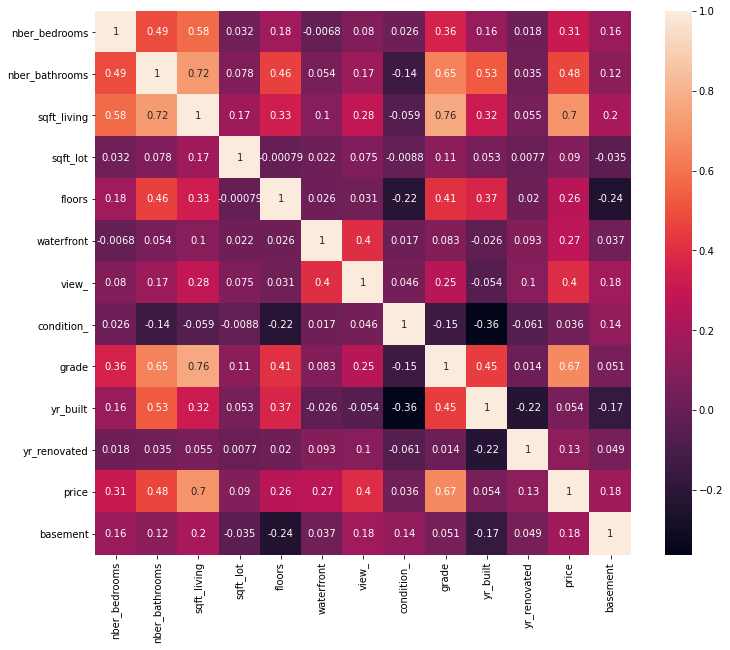

In [21]:
corr_matrix=num_df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

##### We can find high correlation between sqft_living and bathrooms; grade and bathrooms. To keep in mind...

### Checking for outliers

In [22]:
num_df.describe()

,nber_bedrooms,nber_bathrooms,sqft_living,sqft_lot,floors,waterfront,view_,condition_,grade,yr_built,yr_renovated,price,basement
count,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000
mean,3.373200,2.313655,2080.321850,1.509941e+04,1.542205,0.007547,0.234292,3.409825,7.657915,1970.999676,84.464787,5.402966e+05,0.392971
std,0.926299,0.864160,918.106125,4.141264e+04,0.567159,0.086549,0.766390,0.650546,1.173200,29.375234,401.821438,3.673681e+05,0.488422
min,1.000000,1.000000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,0.000000,7.800000e+04,0.000000
25%,3.000000,2.000000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1951.000000,0.000000,3.220000e+05,0.000000
50%,3.000000,2.000000,1910.000000,7.618000e+03,2.000000,0.000000,0.000000,3.000000,7.000000,1975.000000,0.000000,4.500000e+05,0.000000
75%,4.000000,3.000000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1997.000000,0.000000,6.450000e+05,1.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,4.000000,1.000000,4.000000,5.000000,13.000000,2015.000000,2015.000000,7.700000e+06,1.000000


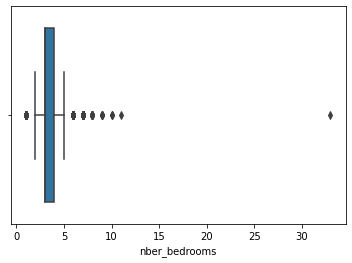

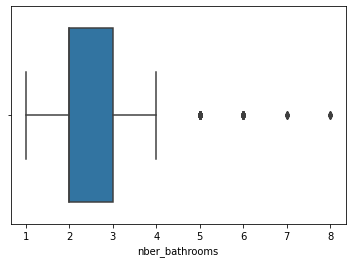

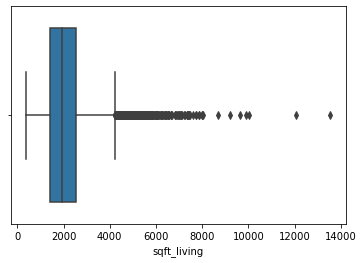

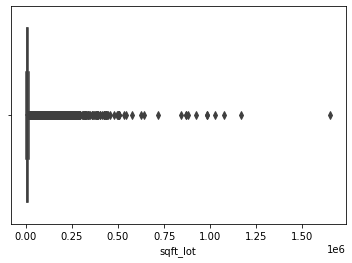

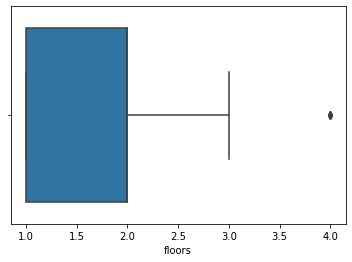

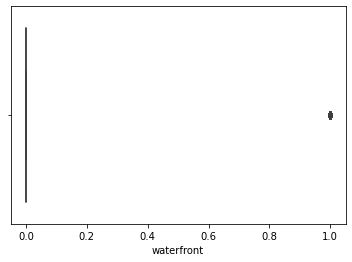

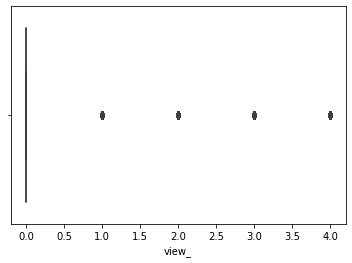

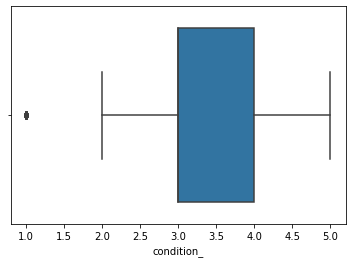

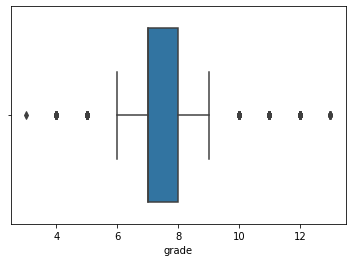

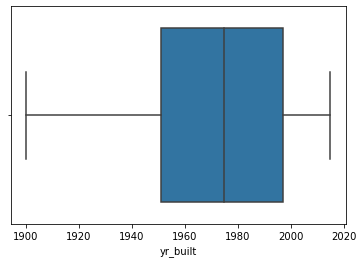

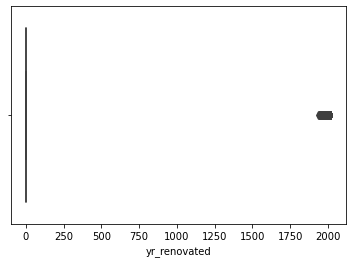

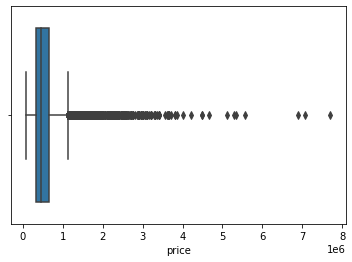

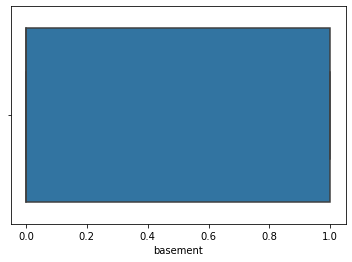

In [23]:
for i in num_df.columns:
    sns.boxplot(num_df[i])
    plt.show()

In [24]:
len(cont_df)

21597

In [25]:
Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)
IQR = Q3 - Q1

Checking how many outliers there are per column. I can compare with the length of cont_df.

In [26]:
((num_df < (Q1 - 1.5 * IQR)) | (num_df > (Q3 + 1.5 * IQR))).sum()

nber_bedrooms      530
nber_bathrooms     187
sqft_living        571
sqft_lot          2419
floors               7
waterfront         163
view_             2122
condition_          29
grade             1905
yr_built             0
yr_renovated       914
price             1158
basement             0
dtype: int64

##### The previous method does not take into account the lower whiskers. Let's check how many outliers we really have:

In [27]:
iqr = np.percentile(num_df['nber_bedrooms'],75) - np.percentile(num_df['nber_bedrooms'],25)
upper_limit = np.percentile(num_df['nber_bedrooms'],75) + 1.5*iqr
lower_limit = np.percentile(num_df['nber_bedrooms'],75) - 1.5*iqr
print("The upper wisker is at: %4.2f" % upper_limit)
print("The lower wisker is at: %4.2f" % lower_limit)
outliers_upper = num_df[num_df['nber_bedrooms'] > upper_limit].index.tolist()
outliers_lower = num_df[num_df['nber_bedrooms'] < lower_limit].index.tolist()
print("The number of points outise the upper wisker is: ",len(outliers_upper))
print("The number of points outise the lower wisker is: ",len(outliers_lower))

The upper wisker is at: 5.50
The lower wisker is at: 2.50
The number of points outise the upper wisker is:  334
The number of points outise the lower wisker is:  2956


In [28]:
iqr = np.percentile(num_df['nber_bathrooms'],75) - np.percentile(num_df['nber_bathrooms'],25)
upper_limit = np.percentile(num_df['nber_bathrooms'],75) + 1.5*iqr
lower_limit = np.percentile(num_df['nber_bathrooms'],75) - 1.5*iqr
print("The upper wisker is at: %4.2f" % upper_limit)
print("The lower wisker is at: %4.2f" % lower_limit)
outliers_upper = num_df[num_df['nber_bathrooms'] > upper_limit].index.tolist()
outliers_lower = num_df[num_df['nber_bathrooms'] < lower_limit].index.tolist()
print("The number of points outise the upper wisker is: ",len(outliers_upper))
print("The number of points outise the lower wisker is: ",len(outliers_lower))

The upper wisker is at: 4.50
The lower wisker is at: 1.50
The number of points outise the upper wisker is:  187
The number of points outise the lower wisker is:  3935


In [29]:
iqr = np.percentile(num_df['sqft_living'],75) - np.percentile(num_df['sqft_living'],25)
upper_limit = np.percentile(num_df['sqft_living'],75) + 1.5*iqr
lower_limit = np.percentile(num_df['sqft_living'],75) - 1.5*iqr
print("The upper wisker is at: %4.2f" % upper_limit)
print("The lower wisker is at: %4.2f" % lower_limit)
outliers_upper = num_df[num_df['sqft_living'] > upper_limit].index.tolist()
outliers_lower = num_df[num_df['sqft_living'] < lower_limit].index.tolist()
print("The number of points outise the upper wisker is: ",len(outliers_upper))
print("The number of points outise the lower wisker is: ",len(outliers_lower))

The upper wisker is at: 4230.00
The lower wisker is at: 870.00
The number of points outise the upper wisker is:  571
The number of points outise the lower wisker is:  730


In [30]:
iqr = np.percentile(num_df['sqft_lot'],75) - np.percentile(num_df['sqft_lot'],25)
upper_limit = np.percentile(num_df['sqft_lot'],75) + 1.5*iqr
lower_limit = np.percentile(num_df['sqft_lot'],75) - 1.5*iqr
print("The upper wisker is at: %4.2f" % upper_limit)
print("The lower wisker is at: %4.2f" % lower_limit)
outliers_upper = num_df[num_df['sqft_lot'] > upper_limit].index.tolist()
outliers_lower = num_df[num_df['sqft_lot'] < lower_limit].index.tolist()
print("The number of points outise the upper wisker is: ",len(outliers_upper))
print("The number of points outise the lower wisker is: ",len(outliers_lower))

The upper wisker is at: 19152.50
The lower wisker is at: 2217.50
The number of points outise the upper wisker is:  2419
The number of points outise the lower wisker is:  1321


In [31]:
iqr = np.percentile(num_df['waterfront'],75) - np.percentile(num_df['waterfront'],25)
upper_limit = np.percentile(num_df['waterfront'],75) + 1.5*iqr
lower_limit = np.percentile(num_df['waterfront'],75) - 1.5*iqr
print("The upper wisker is at: %4.2f" % upper_limit)
print("The lower wisker is at: %4.2f" % lower_limit)
outliers_upper = num_df[num_df['waterfront'] > upper_limit].index.tolist()
outliers_lower = num_df[num_df['waterfront'] < lower_limit].index.tolist()
print("The number of points outise the upper wisker is: ",len(outliers_upper))
print("The number of points outise the lower wisker is: ",len(outliers_lower))

The upper wisker is at: 0.00
The lower wisker is at: 0.00
The number of points outise the upper wisker is:  163
The number of points outise the lower wisker is:  0


In [32]:
iqr = np.percentile(num_df['view_'],75) - np.percentile(num_df['view_'],25)
upper_limit = np.percentile(num_df['view_'],75) + 1.5*iqr
lower_limit = np.percentile(num_df['view_'],75) - 1.5*iqr
print("The upper wisker is at: %4.2f" % upper_limit)
print("The lower wisker is at: %4.2f" % lower_limit)
outliers_upper = num_df[num_df['view_'] > upper_limit].index.tolist()
outliers_lower = num_df[num_df['view_'] < lower_limit].index.tolist()
print("The number of points outise the upper wisker is: ",len(outliers_upper))
print("The number of points outise the lower wisker is: ",len(outliers_lower))

The upper wisker is at: 0.00
The lower wisker is at: 0.00
The number of points outise the upper wisker is:  2122
The number of points outise the lower wisker is:  0


In [33]:
iqr = np.percentile(num_df['condition_'],75) - np.percentile(num_df['condition_'],25)
upper_limit = np.percentile(num_df['condition_'],75) + 1.5*iqr
lower_limit = np.percentile(num_df['condition_'],75) - 1.5*iqr
print("The upper wisker is at: %4.2f" % upper_limit)
print("The lower wisker is at: %4.2f" % lower_limit)
outliers_upper = num_df[num_df['condition_'] > upper_limit].index.tolist()
outliers_lower = num_df[num_df['condition_'] < lower_limit].index.tolist()
print("The number of points outise the upper wisker is: ",len(outliers_upper))
print("The number of points outise the lower wisker is: ",len(outliers_lower))

The upper wisker is at: 5.50
The lower wisker is at: 2.50
The number of points outise the upper wisker is:  0
The number of points outise the lower wisker is:  199


In [34]:
iqr = np.percentile(num_df['grade'],75) - np.percentile(num_df['grade'],25)
upper_limit = np.percentile(num_df['grade'],75) + 1.5*iqr
lower_limit = np.percentile(num_df['grade'],75) - 1.5*iqr
print("The upper wisker is at: %4.2f" % upper_limit)
print("The lower wisker is at: %4.2f" % lower_limit)
outliers_upper = num_df[num_df['grade'] > upper_limit].index.tolist()
outliers_lower = num_df[num_df['grade'] < lower_limit].index.tolist()
print("The number of points outise the upper wisker is: ",len(outliers_upper))
print("The number of points outise the lower wisker is: ",len(outliers_lower))

The upper wisker is at: 9.50
The lower wisker is at: 6.50
The number of points outise the upper wisker is:  1635
The number of points outise the lower wisker is:  2308


In [35]:
iqr = np.percentile(num_df['price'],75) - np.percentile(num_df['price'],25)
upper_limit = np.percentile(num_df['price'],75) + 1.5*iqr
lower_limit = np.percentile(num_df['price'],75) - 1.5*iqr
print("The upper wisker is at: %4.2f" % upper_limit)
print("The lower wisker is at: %4.2f" % lower_limit)
outliers_upper = num_df[num_df['price'] > upper_limit].index.tolist()
outliers_lower = num_df[num_df['price'] < lower_limit].index.tolist()
print("The number of points outise the upper wisker is: ",len(outliers_upper))
print("The number of points outise the lower wisker is: ",len(outliers_lower))

The upper wisker is at: 1129500.00
The lower wisker is at: 160500.00
The number of points outise the upper wisker is:  1158
The number of points outise the lower wisker is:  281


##### yr_renovated is not counted because all properties with a renovation date are considered outliers.
##### In a next step, it might prove useful to create a column marking which properties are outliers and which are not.

### Checking distributions

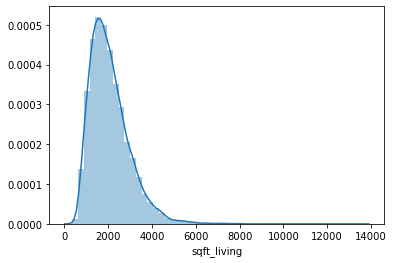

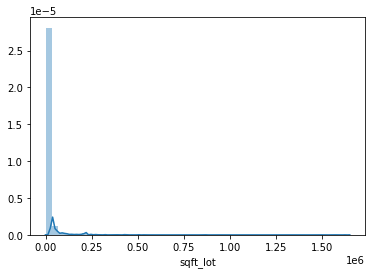

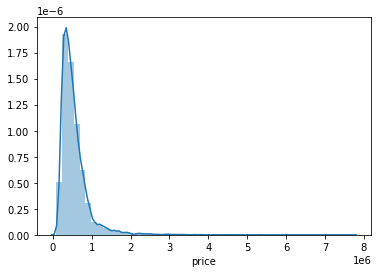

In [36]:
for i in cont_df.columns:
    sns.distplot(cont_df[i])
    plt.show()

### Data transformation: LOG 
The plots are positively skewed (therefore LOG transformation is appropriate). In previous iterations I used a Box-Cox transformation and a LOG transformation. The model performed slightly better with a LOG transformation, leading me to skip the Box-Cox.

We can see that the transformation has approximated all continuous values towards a more normal distribution.

In [37]:
def log_transform(x):
    if np.isfinite(x) and x!=0: 
        return np.log(x)
    else:
        return np.NAN # We are returning NaNs so that we can replace them later

In [38]:
cont_df_log = cont_df.applymap(log_transform)
cont_df_log.head()

,sqft_living,sqft_lot,price
house_id,,,
7129300520,7.073270,8.639411,12.309982
6414100192,7.851661,8.887653,13.195614
5631500400,6.646391,9.210340,12.100712
2487200875,7.580700,8.517193,13.311329
1954400510,7.426549,8.997147,13.142166


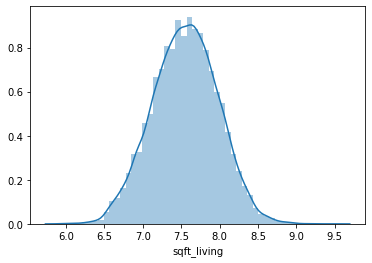

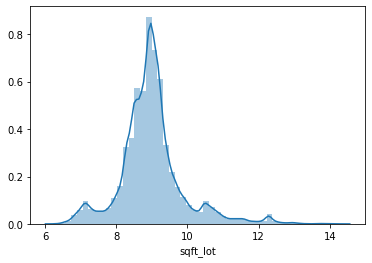

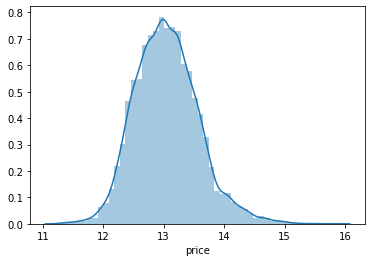

In [39]:
for i in cont_df_log.columns:
    sns.distplot(cont_df_log[i])
    plt.show()

### Categorical columns
I will dummify zipcode, the only categorical column. I previously dropped latitude and longitude because zipcode was giving more useful data for the model and otherwise there would be an information overlap.

In [40]:
dummy_data = pd.get_dummies(cat_df, columns=['zipcode'],drop_first=True)
dummy_data.head()

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
house_id,,,,,,,,,,,,,,,,,,,,,
7129300520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6414100192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5631500400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2487200875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1954400510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Concatenating data

In [41]:
data_concat = pd.concat([cont_df_log,disc_df,dummy_data], axis=1)
data_concat.head()

,sqft_living,sqft_lot,price,nber_bedrooms,nber_bathrooms,floors,waterfront,view_,condition_,grade,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
house_id,,,,,,,,,,,,,,,,,,,,,
7129300520,7.073270,8.639411,12.309982,3,1,1,0,0,3,7,...,0,0,0,0,0,0,1,0,0,0
6414100192,7.851661,8.887653,13.195614,3,2,2,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
5631500400,6.646391,9.210340,12.100712,2,1,1,0,0,3,6,...,0,0,0,0,0,0,0,0,0,0
2487200875,7.580700,8.517193,13.311329,4,3,1,0,0,5,7,...,0,0,0,0,0,0,0,0,0,0
1954400510,7.426549,8.997147,13.142166,3,2,1,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0


### Split data between dependent and independent variables
Remember that a LOG transformation was performed to the dependent variable 'price'. This will have to be undone after getting the predictions.

In [42]:
y = data_concat[['price']]
X = data_concat.drop(['price'], axis=1)

### Standardizing data
In previous tests I saw that standardizing, instead of normalizing, slightly improved all three models tested.

In [43]:
transformer = StandardScaler().fit(X)
x_standarized = transformer.transform(X)
x_standarized = pd.DataFrame(x_standarized)

# 6. Building Model

#### Split data into train and test sets.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x_standarized, y, test_size=0.3, random_state=100)

#### Fitting the model and getting predictions.

In [45]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train, y_train)

In [46]:
lm_predictions = lm_model.predict(X_test)

#### I invert the LOG transformation which was previously applied to the target variable. 

In [47]:
lm_predictions_exp = np.exp(lm_predictions)
y_test_exp = np.exp(y_test)

#### Error metrics

In [48]:
#RE = (lm_predictions-y_test)/y_test
MAE = mean_absolute_error(y_test_exp,lm_predictions_exp)
MSE = mean_squared_error(y_test_exp,lm_predictions_exp)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test_exp,lm_predictions_exp)

#print("The relative error of the model in the test set is: %6.2f" % (RE))
print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 74839.57
The mean squared error of the model in the test set is: 17779651615.26
The root mean squared error of the model in the test set is: 133340.36
The R2 of the model in the test set is: 0.88


#### Plot of predictions against real values
We can see that there is a clear linear relationship. Ideally we would get a line. We can see that outliers are probably hurting the model.

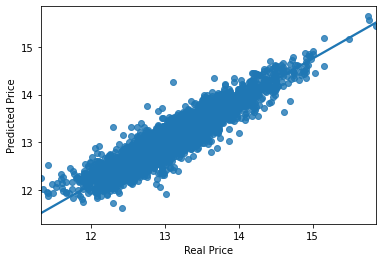

In [57]:
sns.regplot(x=y_test, y=lm_predictions)
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.show()

In [ ]:
sns.regplot(x=y_test, y=lm_predictions)
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.show()

#### I make a dataframe of my predictions and real prices (y_test_exp)

In [50]:
lm_predictions_df = pd.DataFrame(lm_predictions_exp)

In [51]:
lm_predictions_df = lm_predictions_df.rename(columns = {0:'predicted_price'})

In [52]:
lm_predictions_df = lm_predictions_df.round(1)

In [53]:
y_test_exp_df = pd.DataFrame(y_test_exp).reset_index()

#### I merge both dataframes to be able to compare

In [54]:
comparison = y_test_exp_df.merge(lm_predictions_df, left_index=True, right_index=True)

In [55]:
comparison.head()

,house_id,price,predicted_price
0,1959702045,900000.0,544295.4
1,5104530240,346950.0,362667.9
2,4343800080,305000.0,249693.0
3,3034200660,507000.0,481917.1
4,2571910160,283000.0,278845.7


##### I manually check Mean Absolute Error of resulting dataframe to make sure that the index positions have remained the same:

In [56]:
sum(abs(np.array(comparison['price'])-np.array(comparison['predicted_price'])))/len(comparison)

74839.57379629587

# 7. Conclusions and next steps

• The R2 is below .90, although it came very close. 

• The model will be relatively good at predicting normally priced houses. The challenge will come with higher priced properties.

• There are some variables that seem to influence the elevated price of the exclusive properties from our dataset:

    Size matters! sqft_living and sqft_plot determine the price of houses, and directly related to the size of the house
    and plot, houses with high amounts of bedrooms and bathrooms tend to indicate more expensive houses. 

    Labels are also very important in distinguishing the most exclusive properties. Waterfront, Views and Grade are 
    expensive house indicators.

• A necessary next step would be to establish clear parameters for expensive houses. By tagging exclusive properties, we can compare the predictions with real prices to determine the error of the model for these specific houses. 

• Another option would be to create 2 independent models (and 2 dataframes), one for "normal" houses and one for "exclusive" houses. 

• If keeping one dataframe, we could make an extra model from the outliers in the train set in order to teach the first model how to best predict higher values houses. 